<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20230118ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta

import os
import re

from functools import reduce
from collections import defaultdict

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'sales_vs_discount.csv',
 'sample-sales-data.csv',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_orders_dataset.csv',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 'match_result_test.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'online_retail.xlsx',
 'online_retail_II.xlsx',
 'mall_customers.csv',
 'ecommerce-data.csv',
 'mock_sales_data.csv',
 'sales.csv',
 'groceries.csv',
 'app_wau.csv',
 '1_order_payments_dataset.csv',
 'ab_experiment.csv',
 'bz_data_analyis.csv',
 'sales_data_with_stores.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 '1_customers_dataset.csv',
 'test.csv',
 'sample_data']

In [4]:
df = pd.read_csv('app_wau.csv')
df.occurred_at = pd.to_datetime(df.occurred_at)
df['date'] = df.occurred_at.to_numpy().astype('datetime64[D]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['weekday'] = df['date'].dt.weekday
df.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,date,week,weekday
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,4
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,4
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,4
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,4
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,4


In [6]:
list_weekday = dict(zip(range(7),['mn','tu','wd','th','fr','sa','su']))
df['weekday'] = df['weekday'].apply(lambda x : list_weekday.get(x,x))
df['weekday'].astype('category').cat.reorder_categories([a for a in list_weekday.values()], inplace = True)
df.head()

<ipython-input-6-c42eb55bf8ad>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.


,user_id,occurred_at,event_type,event_name,location,device,user_type,date,week,weekday
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr


In [12]:
df['device'].sort_values().unique()

array(['acer aspire desktop', 'acer aspire notebook', 'amazon fire phone',
       'asus chromebook', 'dell inspiron desktop',
       'dell inspiron notebook', 'hp pavilion desktop', 'htc one',
       'ipad air', 'ipad mini', 'iphone 4s', 'iphone 5', 'iphone 5s',
       'kindle fire', 'lenovo thinkpad', 'mac mini', 'macbook air',
       'macbook pro', 'nexus 10', 'nexus 5', 'nexus 7', 'nokia lumia 635',
       'samsumg galaxy tablet', 'samsung galaxy note',
       'samsung galaxy s4', 'windows surface'], dtype=object)

In [15]:
list_maker = dict(zip(
    df['device'].sort_values().unique(),
    ['acer','acer','amazone',
     'asus','dell',
     'dell','hp','htc',
     'apple','apple','apple','apple','apple',
     'amazon','lenovo','apple','apple',
     'apple','google','google','google','nokia',
     'samsung','samsung',
     'samsung','ms']
))
df['maker'] = df['device'].apply(lambda x : list_maker.get(x,x))
df.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,date,week,weekday,maker
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr,dell
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr,dell
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr,dell
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr,dell
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-05-02,2014-04-28,fr,dell


In [24]:
cnt_df = df[(df.event_name == 'login') & (df.location == 'United States')][['user_id','maker', 'user_type', 'week','weekday']].drop_duplicates()
cnt_df = cnt_df.groupby(['week','weekday','maker','user_type'])['user_id'].count().reset_index().rename(columns = {'user_id':'au'})
cnt_df['user_type'] = cnt_df['user_type'].astype(str)
cnt_df['week'] = cnt_df['week'].astype(str)
cnt_df['ratio'] = cnt_df.groupby(['week', 'maker', 'user_type'])['au'].apply(lambda x : round(x/max(x)*100,2))
cnt_df.head()

,week,weekday,maker,user_type,au,ratio
0,2014-04-28,fr,acer,1.0,2,100.0
1,2014-04-28,fr,amazon,1.0,1,100.0
2,2014-04-28,fr,apple,1.0,29,100.0
3,2014-04-28,fr,apple,2.0,12,100.0
4,2014-04-28,fr,apple,3.0,18,100.0


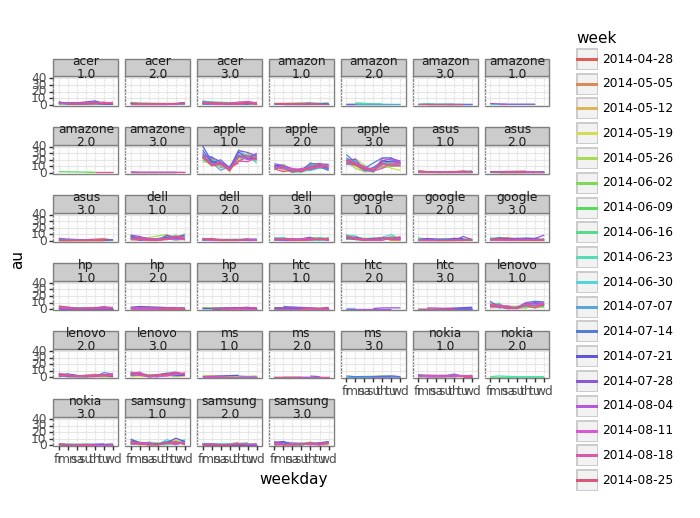

<ggplot: (8787135787560)>

In [20]:
(
    ggplot(cnt_df, aes('weekday', 'au', color = 'week', group = 'week')) +
    gg.geom_line() +
    gg.facet_wrap('~maker+user_type') +
    gg.theme_bw()
)

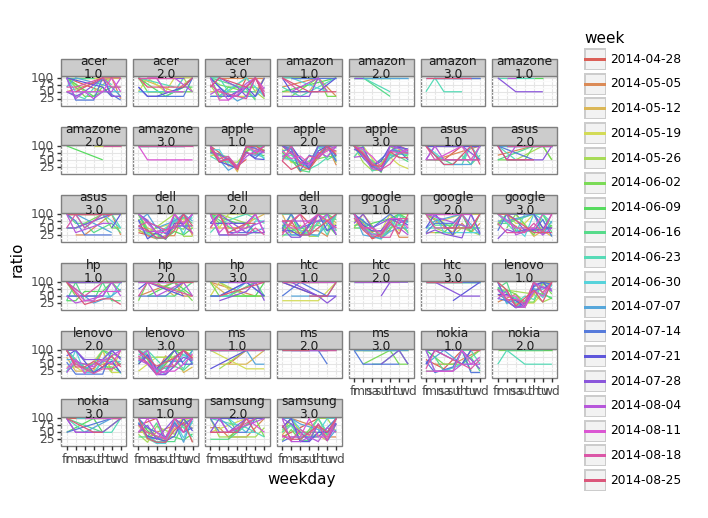

<ggplot: (8787131329898)>

In [25]:
(
    ggplot(cnt_df, aes('weekday', 'ratio', color = 'week', group = 'week')) +
    gg.geom_line() +
    gg.facet_wrap('~maker+user_type') +
    gg.theme_bw()
)

In [26]:
cnt_type = df[(df.event_name == 'login') & (df.location == 'United States')][['user_id','user_type']].drop_duplicates()
cnt_type = cnt_type.groupby(['user_type'])['user_id'].count().reset_index().rename(columns = {'user_id':'au'})
cnt_type.head()

,user_type,au
0,1.0,512
1,2.0,462
2,3.0,767


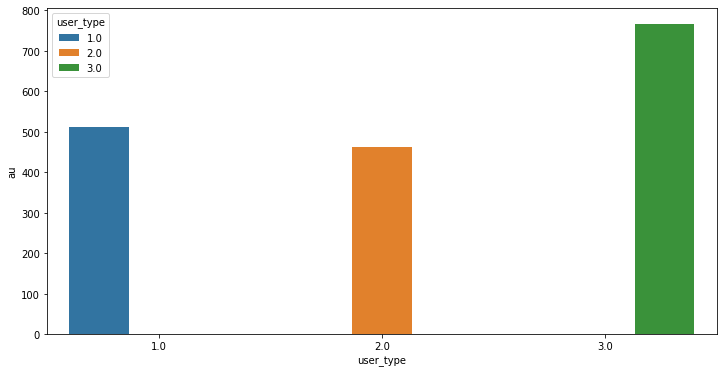

In [27]:
plt.figure(figsize = (12, 6))
sns.barplot(data = cnt_type, x=  'user_type', y = 'au', hue = 'user_type')

# Iterators

In [28]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [29]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}